In [1]:
import argparse
import cv2
import numpy as np
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import Compose
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from SLAM.TUM_dataset import TUMVisualInertialDataset

os.chdir("./DepthAnything/")
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

### Initialize Dataset

(2, 511, 511, 3) (110,) (110, 3) (110, 3) (2, 7)


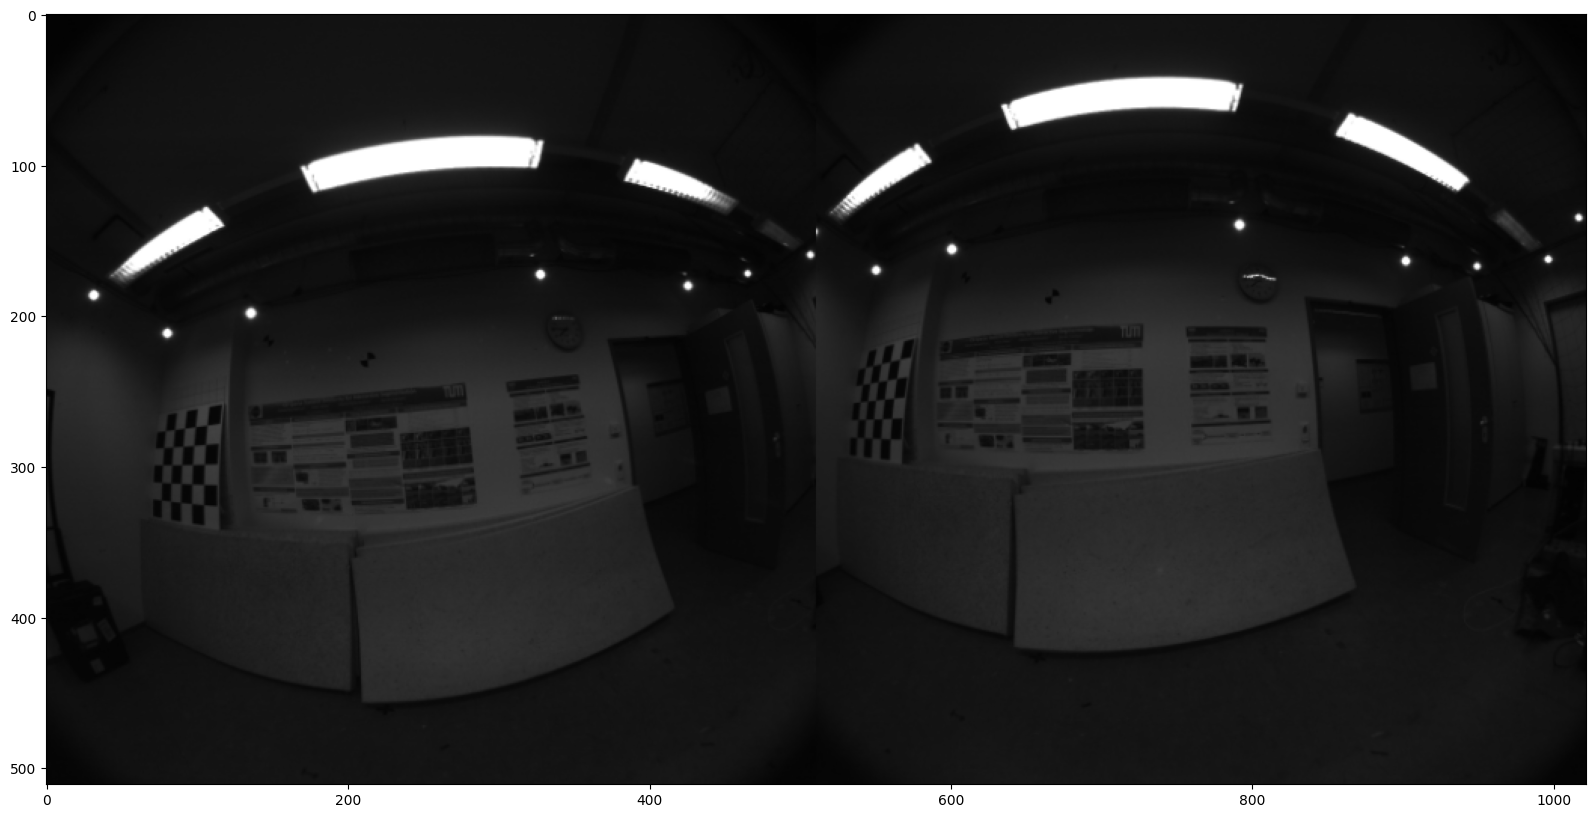

In [2]:
seq_len = 2
dataset = TUMVisualInertialDataset(path='/home/ilari/Downloads/dataset-corridor4_512_16/dso', sequence_length=seq_len, skip_frames=10, )
X = dataset[50]
print(X['cam0'].shape, X['dt'].shape, X['acc'].shape, X['gyro'].shape, X['gt_pose'].shape)
s, h, w, c = X['cam0'].shape
plt.figure(figsize=(30,10))
plt.imshow(np.concatenate(tuple(X['cam0']), axis=1));

### Initialize Models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Depth Anything
# depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_vitb14').to(device).eval()
# total_params = sum(param.numel() for param in depth_anything.parameters())
# print('DepthAnything parameters: {:.2f}M'.format(total_params / 1e6))

class ApplyTransformsToBatch:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, batch):
        # Convert PIL Images in batch to tensors and apply transformations
        transformed_batch = [self.transform({'image': img})['image'] for img in batch]
        # Stack the transformed tensors to create a new batch
        return np.stack(transformed_batch)

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # PrepareForNet(), this makes the image (and training masks) contiguous and floats
])

transform_batch = ApplyTransformsToBatch(transform)

# Extractor and matcher
# extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
# matcher = LightGlue(features="superpoint").eval().to(device)

In [4]:
for i, data in enumerate(dataset):
    #features = extract_keypoints(data['cam0'], extractor, device)
    batched_images = transform_batch(np.transpose(data['cam0'], (0, 3, 1, 2)))
    batched_images = torch.from_numpy(batched_images).to(device)
    print(f"Batched size: {batched_images.shape}")

    with torch.no_grad():
        depth = depth_anything(batched_images)
    print(depth.shape)
    depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0

error: OpenCV(4.9.0) /io/opencv/modules/core/src/alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 186830201152 bytes in function 'OutOfMemoryError'


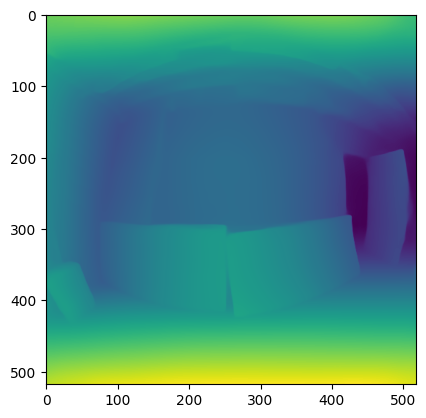

In [ ]:
plt.imshow(depth.cpu().numpy())